<a href="https://colab.research.google.com/github/brandonclark314/CatsandDogs/blob/main/CatsandDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Here I've copied the professor's notebook that is linked below in the Sources section.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-22 02:01:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   110MB/s    in 0.6s    

2020-04-22 02:01:48 (110 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Here I've changed the convolutional base to Xception instead of VGG16

### Load the convolutional base

In [ ]:
from keras.applications.xception import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Freeze the convolutional base

In [ ]:
conv_base.trainable = False

### Here I have the model set up with a single Dense layer with 256 nodes and relu activation and a Dense layer with one node and sigmoid activation. I change the model in Problem 3 Notebook 2 to have a Dense layer with 32 nodes and relu activation and a Dense layer with 2 nodes and relu activation and a Dense layer with one node and sigmoid activation. I would expect this model to perform worse than the model in Problem 3 Notebook 1 because it overcomplicates the problem.

### Concatenate the convolutional base and densely connected layers

In [ ]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_7 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 33,969,193
Trainable params: 13,107,713
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 20s 204ms/step - loss: 0.4723 - acc: 0.7605 - val_loss: 0.5213 - val_acc: 0.9540
Epoch 2/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3775 - acc: 0.8165 - val_loss: 0.5719 - val_acc: 0.9650
Epoch 3/30
100/100 [==============================] - 17s 172ms/step - loss: 0.3639 - acc: 0.8290 - val_loss: 0.6578 - val_acc: 0.9510
Epoch 4/30
100/100 [==============================] - 17s 174ms/step - loss: 0.3544 - acc: 0.8410 - val_loss: 0.0882 - val_acc: 0.9680
Epoch 5/30
100/100 [==============================] - 17s 173ms/step - loss: 0.2972 - acc: 0.8720 - val_loss: 0.1568 - val_acc: 0.9430
Epoch 6/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3260 - acc: 0.8550 - val_loss: 3.4319e-04 - val_acc: 0.9700
Epoch 7/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3154 - acc: 0.8650 - va

## Display curves of loss and accuracy during training

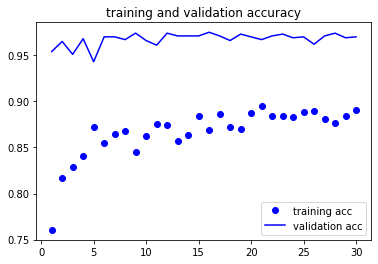

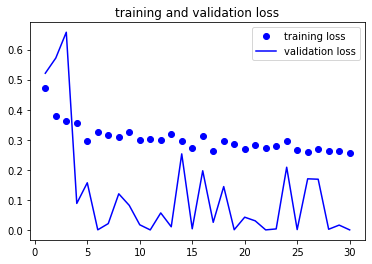

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block14_sepconv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

Freezing


In [ ]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 22s 217ms/step - loss: 0.2413 - acc: 0.9030 - val_loss: 0.1517 - val_acc: 0.9490
Epoch 2/30
100/100 [==============================] - 18s 178ms/step - loss: 0.2492 - acc: 0.8965 - val_loss: 0.0184 - val_acc: 0.9450
Epoch 3/30
100/100 [==============================] - 18s 177ms/step - loss: 0.2333 - acc: 0.9005 - val_loss: 0.0684 - val_acc: 0.9460
Epoch 4/30
100/100 [==============================] - 18s 177ms/step - loss: 0.2212 - acc: 0.9155 - val_loss: 0.1084 - val_acc: 0.9400
Epoch 5/30
100/100 [==============================] - 18s 178ms/step - loss: 0.2392 - acc: 0.9005 - val_loss: 0.1998 - val_acc: 0.9380
Epoch 6/30
100/100 [==============================] - 18s 181ms/step - loss: 0.2508 - acc: 0.9000 - val_loss: 0.3048 - val_acc: 0.9340
Epoch 7/30
100/100 [==============================] - 18s 177ms/step - loss: 0.2387 - acc: 0.9055 - val_loss: 0.0371 - val_acc: 0.9400
Epoch 8/30
100/100 [==============================] - 1

## Display learning curves during fine-tuning

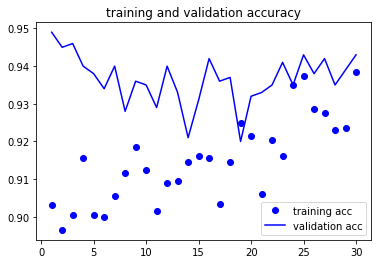

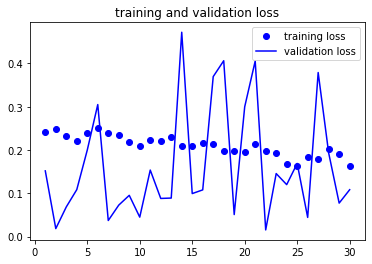

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [ ]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [ ]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.006010968238115311
Validation accuracy: 0.9430000185966492


# Sources
## Here are all of the resources I used when making this notebook.
https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF#scrollTo=YhEoI8ZTok-X&forceEdit=true&sandboxMode=true
https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF